# Dormant promoters

In [114]:
# Get packages
using CSV, DataFrames, wgregseq, CairoMakie, Statistics, DelimitedFiles, Dates, Colors, FASTX, BioSequences, StatsBase, ProgressMeter

# Set colors and plotting style
wgregseq.plotting_style.default_makie!()
update_theme!(Theme(font = "Lato", titlefont="Lato"))
colors_dict = wgregseq.plotting_style.my_color_dict
colors = [colors_dict["blue1"], colors_dict["orange1"], colors_dict["green1"]]

df_sites = CSV.read("known_sites.txt", DataFrame)

Row,promoter,type,start,end
,String7,String7,Int64,Int64
1,rspAp,rep,-39,-31
2,rspAp,act,-71,-50
3,znuCp,rep,-21,2
4,znuCp,act,-36,-20
5,xylAp,rep,-33,-17
6,xylAp,act,-50,-33
7,xylAp,rep,-56,-40
8,xylAp,act,-71,-56
9,xylAp,act,-92,-71


In [14]:
df_standards = CSV.read("../../../data/gold_standards.csv", DataFrame)

df_map = CSV.read(
    "../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", 
    DataFrame, 
);

# Filter out unnannotad sequences
df_map = df_map[df_map.name .!= "*", :]

# Filter out non-unique barcodes
gdf = groupby(df_map[(df_map.map_count .> 2), :], :barcode)
_df = DataFrame()
for df in gdf
    if nrow(df) == 1
        append!(_df, df)
    end
end
df_map = copy(_df);

# Get twist order to get wild type sequences
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_seqs[1:1501:119*1501, :];
insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])

df_wt.promoter_seq |> unique |> length
df_map = leftjoin(df_map, rename(df_wt[!, [:promoter, :promoter_seq]], :promoter => :name), on="name")
rename!(df_map, :promoter_seq => :wt_seq);

In [65]:
lacUV5_emat = CSV.read("../../../data/lacUV5_emat.txt", DataFrame, comment="#", header=["A", "C", "G", "T"]) |> Matrix

41×4 Matrix{Float64}:
 -0.313427   -0.198978   -0.291059   -0.237371
 -0.280792   -0.0924429  -0.313427   -0.11777
 -0.15885    -0.196853   -0.212634   -0.313427
 -0.313427   -0.179702   -0.312079   -0.184001
  0.0651327  -0.133555   -0.313427    0.495313
  0.305961    0.681616    0.36014    -0.313427
  0.122283    0.247441    0.171605   -0.313427
  1.50068     1.49097    -0.313427    0.633869
 -0.313427    1.03225    -0.138758    0.699062
  1.06464    -0.214039    1.11962    -0.313427
 -0.313427    0.655413    0.295806    0.0242208
 -0.313427   -0.0649198  -0.117951   -0.216438
 -0.206301   -0.0904521  -0.313427   -0.213711
  ⋮                                  
  0.384259    0.791828    1.09396    -0.313427
 -0.313427    1.30369     1.1486      1.24711
 -0.122973    0.168763    0.288229   -0.313427
 -0.313427    0.290512    0.469126    0.54208
 -0.313427   -0.0121504   0.472765    0.51822
  0.67575     1.21418     0.992702   -0.313427
 -0.313427    0.173084   -0.0706913   0.110672
 -0

In [15]:
function get_dataset(i)
    df_DNA = CSV.read(
        "../../../data/extracted_barcodes/20230907_barcode/D$(i)_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        header=["ct_0", "barcode"]
    )
    # import RNA
    df_RNA = CSV.read(
        "../../../data/extracted_barcodes/20230907_barcode/R$(i)_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        header=["ct_1", "barcode"]
    )
    
    # merge DNA and RNA reads
    df = outerjoin(df_DNA, df_RNA, on=:barcode)
    
    # replace missing reads with 0
    replace!(df.ct_0, missing => 0)
    replace!(df.ct_1, missing => 0)
    
    # identify promoter sequences
    df = innerjoin(df, df_map, on=:barcode)
    
    # compute total counts
    insertcols!(df, 1, :ct => df.ct_0 .+ df.ct_1)
    insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
    
    # Turn sequences into integer
    insertcols!(df, 3, :int_promoter => wgregseq.footprints.make_int.(df[:, :promoter]))
    insertcols!(df, 3, :int_wt => wgregseq.footprints.make_int.(df[:, :wt_seq]));
    return df
end

get_dataset (generic function with 1 method)

In [16]:
function expression_shifts(df)
    _df = copy(df) 
    # Compute relative (with pseudo counts)
    if :wt_seq ∉ names(_df)
        freq_mat = wgregseq.footprints.frequency_matrix(_df)[1]
        # find wild type sequence 
        wt_seq = argmax(freq_mat, dims=2) |> vec
        wt_seq = map(x -> x[2], wt_seq)
        wt_seq_dna = [wgregseq.footprints.DNA_dict_rev[x] for x in wt_seq]

        function is_mut(x)
            return x .!= wt_seq
        end

        insertcols!(_df, 4, :is_mutated => is_mut.(_df.int_promoter))
    else
        function is_mut(x, y)
            return x .!= y
        end
        insertcols!(_df, 4, :is_mutated => is_mut.(_df.int_promoter, df.int_wt))
    end

    mean_rel_counts = mean(_df.relative_counts)
    a = (_df.relative_counts .- mean_rel_counts) .* _df.is_mutated
    b = wgregseq.utils.onehot_encoder.(_df.promoter)

    ex_shift_arr = zeros(160, 4)
    for i in 1:nrow(_df)
        ex_shift_arr += a[i] .* b[i]
    end

    return ex_shift_arr ./ sum(b, dims=1)[1]
end

expression_shifts (generic function with 1 method)

## araB

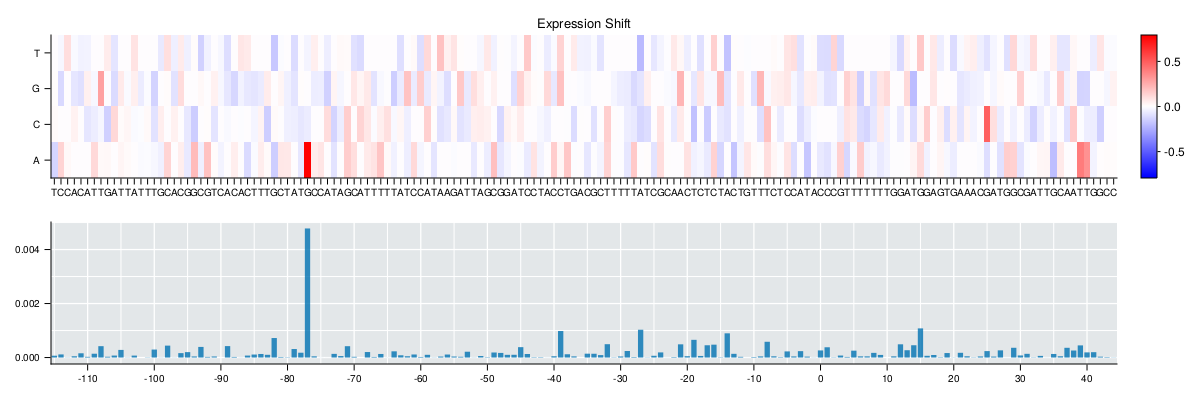

In [59]:
df = get_dataset(1)

fig = Figure(resolution=(1200, 400))
wt_seq = df[df.name .== prom, :wt_seq][1] |> collect
ax1 = Axis(fig[1, 1], xticks=(-115:44, string.(wt_seq)), title="Expression Shift", yticks=([1, 2, 3, 4], ["A", "C", "G", "T"]))


prom = "araBp"
x = expression_shifts(df[df.name .== prom, :])
hm = heatmap!(ax1, -115:44, 1:4, x, colormap=:bwr, colorrange=(-maximum(abs.(x)), maximum(abs.(x))))
Colorbar(fig[1, 2], hm, ticksize=3, ticklabelsize=12)
x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== prom, :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)

d = 0
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

linkxaxes!(ax1, ax2)

xlims!(ax2, -115.5, 44.5)
fig

Excluding high impact mutation.

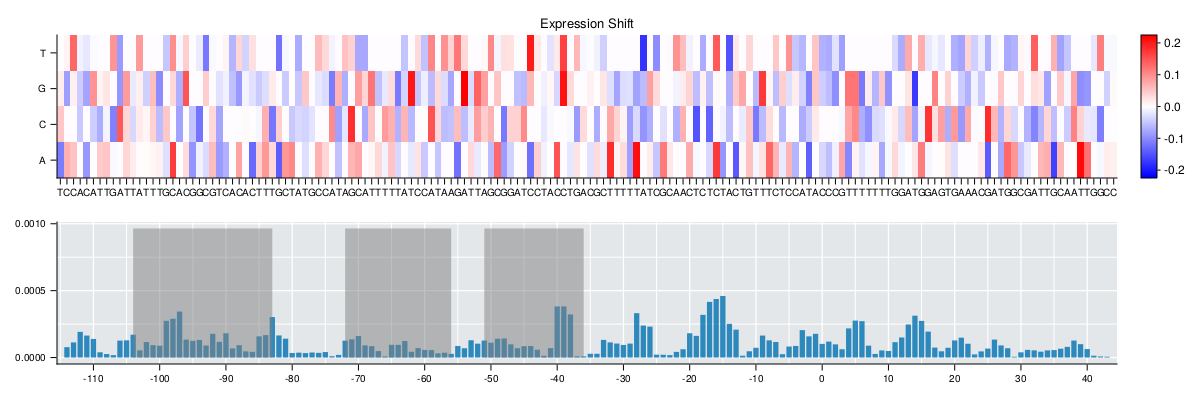

In [115]:
df = get_dataset(1)
df = df[map(x -> collect(x)[39] != 'A', df.promoter), :]

fig = Figure(resolution=(1200, 400))
wt_seq = df[df.name .== prom, :wt_seq][1] |> collect
ax1 = Axis(fig[1, 1], xticks=(-115:44, string.(wt_seq)), title="Expression Shift", yticks=([1, 2, 3, 4], ["A", "C", "G", "T"]))

prom = "araBp"
x = expression_shifts(df[df.name .== prom, :])
replace!(x, NaN => 0)
hm = heatmap!(ax1, -115:44, 1:4, x, colormap=:bwr, colorrange=(-maximum(abs.(x)), maximum(abs.(x))))
Colorbar(fig[1, 2], hm, ticksize=3, ticklabelsize=12)
x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== prom, :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)

d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== prom, :])
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end

linkxaxes!(ax1, ax2)

xlims!(ax2, -115.5, 44.5)
fig

Only sequences with high impact mutation.

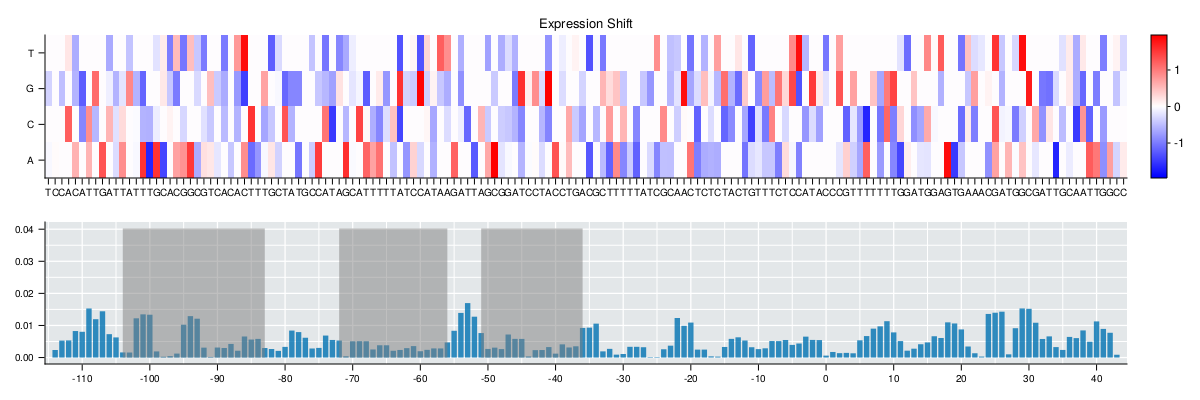

In [131]:
df = get_dataset(1)
df = df[map(x -> collect(x)[39] == 'A', df.promoter), :]

fig = Figure(resolution=(1200, 400))
wt_seq = df[df.name .== prom, :wt_seq][1] |> collect
ax1 = Axis(fig[1, 1], xticks=(-115:44, string.(wt_seq)), title="Expression Shift", yticks=([1, 2, 3, 4], ["A", "C", "G", "T"]))

prom = "araBp"
x = expression_shifts(df[df.name .== prom, :])
replace!(x, NaN => 0)
hm = heatmap!(ax1, -115:44, 1:4, x, colormap=:bwr, colorrange=(-maximum(abs.(x)), maximum(abs.(x))))
Colorbar(fig[1, 2], hm, ticksize=3, ticklabelsize=12)
x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== prom, :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)

d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== prom, :])
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end


linkxaxes!(ax1, ax2)

xlims!(ax2, -115.5, 44.5)
fig

G


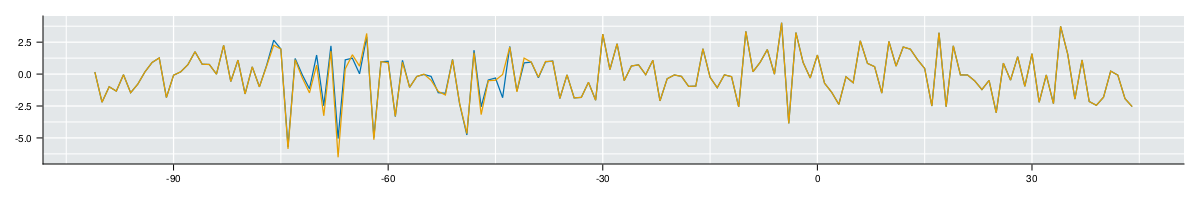

In [132]:
seq = df[df.name .== prom, :wt_seq][1]
x = collect(seq)
println(x[115-76])
x[115-76] = 'A'

int_seq = wgregseq.footprints.make_int("AGTGCCATGTTATCCCTGAATCTAGT" * seq)
int_seq_mut = wgregseq.footprints.make_int("AGTGCCATGTTATCCCTGAATCTAGT" * join(x))
energies = Float64[]
energies_mut = Float64[]
for i in 41:length(int_seq)
    push!(energies, sum([lacUV5_emat[j, int_seq[i-40:i][j]] for j in 1:41]))
    push!(energies_mut, sum([lacUV5_emat[j, int_seq_mut[i-40:i][j]] for j in 1:41]))
end

fig = Figure(resolution=(1200, 200))
ax1 = Axis(fig[1, 1])

lines!(ax1, -101:44, energies)
lines!(ax1, -101:44, energies_mut)
fig

### znuC

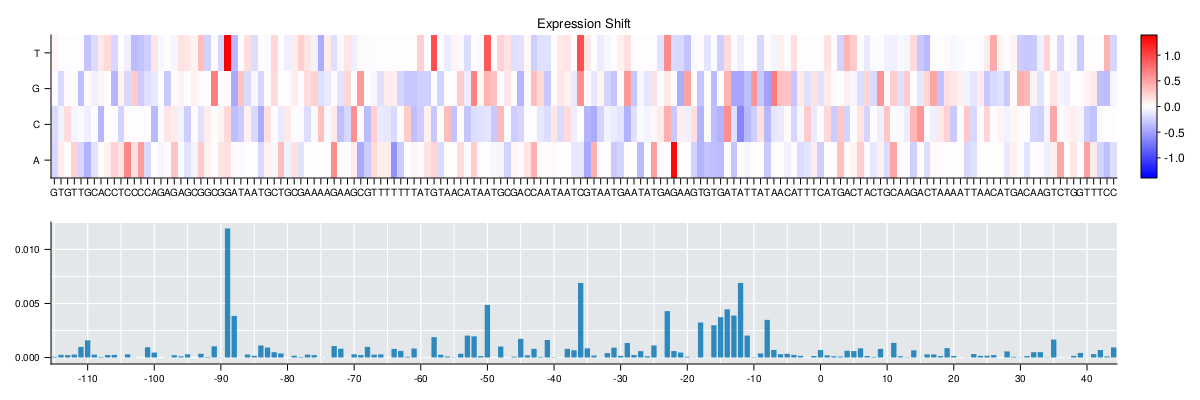

In [133]:
df = get_dataset(1)
prom = "znuCp"
fig = Figure(resolution=(1200, 400))
wt_seq = df[df.name .== prom, :wt_seq][1] |> collect
ax1 = Axis(fig[1, 1], xticks=(-115:44, string.(wt_seq)), title="Expression Shift", yticks=([1, 2, 3, 4], ["A", "C", "G", "T"]))



x = expression_shifts(df[df.name .== prom, :])
hm = heatmap!(ax1, -115:44, 1:4, x, colormap=:bwr, colorrange=(-maximum(abs.(x)), maximum(abs.(x))))
Colorbar(fig[1, 2], hm, ticksize=3, ticklabelsize=12)
x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== prom, :])
ax2 = Axis(fig[2, 1], xticks=-110:10:40)

d = 0
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

linkxaxes!(ax1, ax2)

xlims!(ax2, -115.5, 44.5)
fig

G


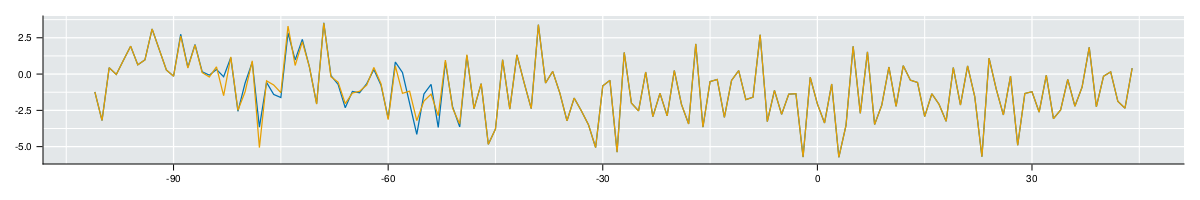

In [134]:
seq = df[df.name .== prom, :wt_seq][1]
x = collect(seq)
println(x[115-88])
x[115-88] = 'T'

int_seq = wgregseq.footprints.make_int("AGTGCCATGTTATCCCTGAATCTAGT" * seq)
int_seq_mut = wgregseq.footprints.make_int("AGTGCCATGTTATCCCTGAATCTAGT" * join(x))
energies = Float64[]
energies_mut = Float64[]
for i in 41:length(int_seq)
    push!(energies, sum([lacUV5_emat[j, int_seq[i-40:i][j]] for j in 1:41]))
    push!(energies_mut, sum([lacUV5_emat[j, int_seq_mut[i-40:i][j]] for j in 1:41]))
end

fig = Figure(resolution=(1200, 200))
ax1 = Axis(fig[1, 1])

lines!(ax1, -101:44, energies)
lines!(ax1, -101:44, energies_mut)
fig